# Original Transformers

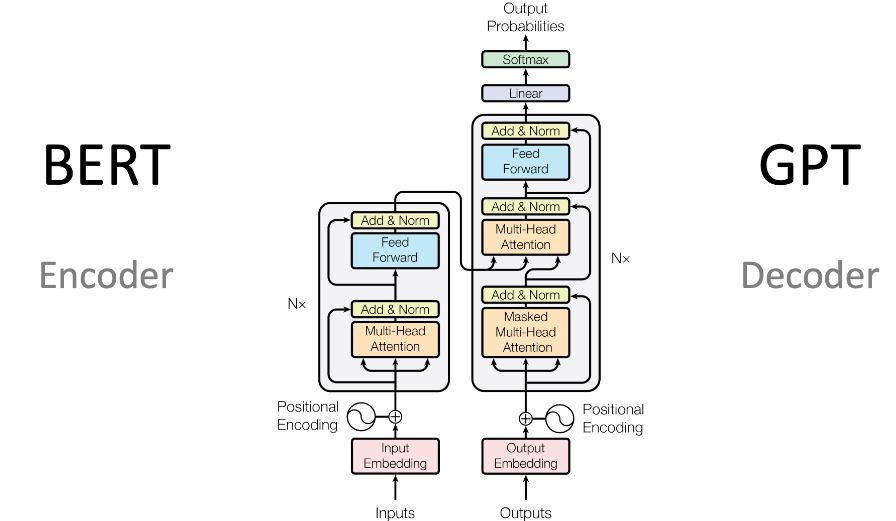

# GPT2 Architecture

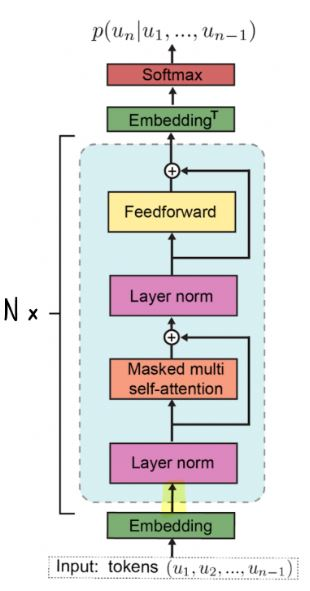 \
Note there is a difference in the add and layer norm where layer norm is being done before and after the self attention
### Repo for GPT2
https://github.com/openai/gpt-2
### Hugging Face 
https://huggingface.co/openai-community/gpt2



In [58]:
from transformers import GPT2LMHeadModel
# GPT2 Paper: https://d4mucfpksywv.cloudfront.net/better-language-models/language-models.pdf


In [49]:
model_hf= GPT2LMHeadModel.from_pretrained("gpt2") #124M (Insert GPT2-xl for the real one)
sd_hf = model_hf.state_dict()

In [50]:
for k,v in sd_hf.items():
    print(k,v.shape)
# transformer.wte.weight torch.Size([50257, 768]) - Lookup table for the tokens [R_vocab x R_dmodel]
# 768   ---> dmodel (length of the vector representation of the token / amount of dimensions required to describe a token) - Vector that represents the token
# 50257 ---> Tokens in vocab in GPT2 (Rv)

#transformer.wpe.weight torch.Size([1024, 768]) - Lookup table for positions [R_context_length x R_dmodel]
# 1024 (Rt - Context length) - Length to which the token

# Input to token embedding is [1024, 50257] - Context Length and the tokens
# So output of Input (stream of text) represented as tokens when multiplied with wte -> [1024, 50257] x[50257, 768] -> [1024, 768]

#h.0-11 ---> 12 Layers in the transformer
# ln_1.weight -> linear layers in the transformers

# Nice Layer Norm Video: https://www.youtube.com/watch?v=G45TuC6zRf4

transformer.wte.weight torch.Size([50257, 768])
transformer.wpe.weight torch.Size([1024, 768])
transformer.h.0.ln_1.weight torch.Size([768])
transformer.h.0.ln_1.bias torch.Size([768])
transformer.h.0.attn.c_attn.weight torch.Size([768, 2304])
transformer.h.0.attn.c_attn.bias torch.Size([2304])
transformer.h.0.attn.c_proj.weight torch.Size([768, 768])
transformer.h.0.attn.c_proj.bias torch.Size([768])
transformer.h.0.ln_2.weight torch.Size([768])
transformer.h.0.ln_2.bias torch.Size([768])
transformer.h.0.mlp.c_fc.weight torch.Size([768, 3072])
transformer.h.0.mlp.c_fc.bias torch.Size([3072])
transformer.h.0.mlp.c_proj.weight torch.Size([3072, 768])
transformer.h.0.mlp.c_proj.bias torch.Size([768])
transformer.h.1.ln_1.weight torch.Size([768])
transformer.h.1.ln_1.bias torch.Size([768])
transformer.h.1.attn.c_attn.weight torch.Size([768, 2304])
transformer.h.1.attn.c_attn.bias torch.Size([2304])
transformer.h.1.attn.c_proj.weight torch.Size([768, 768])
transformer.h.1.attn.c_proj.bias 

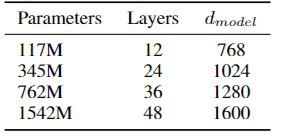

In [51]:
# Wte Embeddings
print(sd_hf["transformer.wte.weight"])
# Lets Flatten the positional embeddings and take the first 20
sd_hf["transformer.wte.weight"].view(-1)[:20]

tensor([[-0.1101, -0.0393,  0.0331,  ..., -0.1364,  0.0151,  0.0453],
        [ 0.0403, -0.0486,  0.0462,  ...,  0.0861,  0.0025,  0.0432],
        [-0.1275,  0.0479,  0.1841,  ...,  0.0899, -0.1297, -0.0879],
        ...,
        [-0.0445, -0.0548,  0.0123,  ...,  0.1044,  0.0978, -0.0695],
        [ 0.1860,  0.0167,  0.0461,  ..., -0.0963,  0.0785, -0.0225],
        [ 0.0514, -0.0277,  0.0499,  ...,  0.0070,  0.1552,  0.1207]])


tensor([-0.1101, -0.0393,  0.0331,  0.1338, -0.0485, -0.0789, -0.2398, -0.0895,
         0.0253, -0.1074, -0.1811, -0.0672,  0.0739, -0.0161,  0.0117,  0.1245,
        -0.0020, -0.0815,  0.0338,  0.2365])

torch.Size([1024, 768])


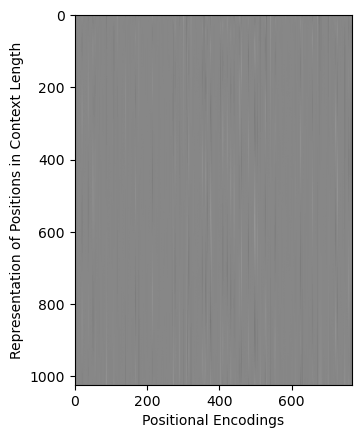

In [52]:
# Postional Embeddings
print(sd_hf["transformer.wpe.weight"].shape)
# Lets Flatten the positional embeddings and take the first 20
sd_hf["transformer.wpe.weight"].view(-1)[:20]

#Lets visualize the positional encodings
# As opposed to original paper where the positional encodings were defined as sines and cosines this model has learnt the parameters of positional encodings
import matplotlib.pyplot as plt
%matplotlib inline

plt.xlabel('Positional Encodings')
plt.ylabel('Representation of Positions in Context Length')
plt.imshow(sd_hf["transformer.wpe.weight"],cmap="gray")
# It has structure
# Every row is a fixed absolute position in the context length
# Positional embeddings end up learning these sinusoids and cosines that represent each of the position
# Essentially this adds/ changes each of the token/embedding representations based on the positions

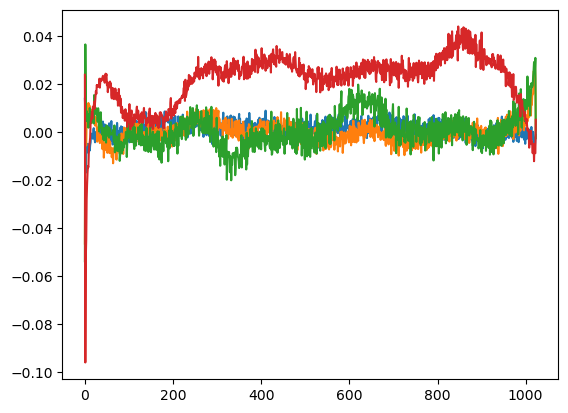

In [53]:
#Lets take one of the columns
plt.plot(sd_hf["transformer.wpe.weight"][:,100])
plt.plot(sd_hf["transformer.wpe.weight"][:,150])
plt.plot(sd_hf["transformer.wpe.weight"][:,200])
plt.plot(sd_hf["transformer.wpe.weight"][:,250])
# Note the red column seems to fire up after 200 upto 800 but wears of in the beginning and the end

In [54]:
# Weight Sharing Scheme
# Intuition you want the layers to behave similar
# 2 tokens very simple semantically for eg: upper case/lower case, same words in different languages
# Similarly given semantically similar output you'd expect them to be similar in the embedding space
# Similar similar embeddings should have the same output of the transformer
print(sd_hf["transformer.wte.weight"].shape)
print(sd_hf["lm_head.weight"].shape)

(sd_hf["lm_head.weight"] == sd_hf["transformer.wte.weight"]).all()

print(sd_hf["transformer.wte.weight"].data_ptr())
print(sd_hf["lm_head.weight"].data_ptr())

torch.Size([50257, 768])
torch.Size([50257, 768])
140685056159808
140685056159808


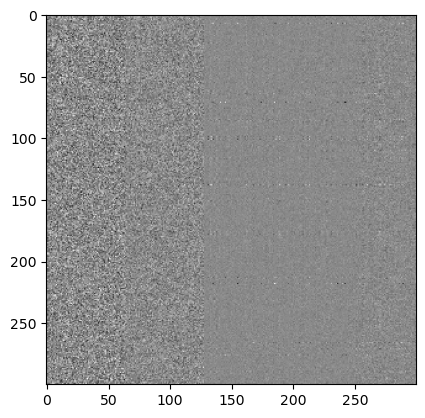

In [55]:
plt.imshow(sd_hf["transformer.h.1.attn.c_attn.weight"][:300,:300],cmap="gray")

In [56]:
from transformers import pipeline, set_seed
generator = pipeline('text-generation', model='gpt2')
set_seed(42)
generator("Hello, I'm a language model,",max_length=30, num_return_sequences=5)

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


[{'generated_text': "Hello, I'm a language model, but what I'm really doing is making a human-readable document. There are other languages, but those are"},
 {'generated_text': "Hello, I'm a language model, not a syntax model. That's why I like it. I've done a lot of programming projects.\n"},
 {'generated_text': "Hello, I'm a language model, and I'll do it in no time!\n\nOne of the things we learned from talking to my friend"},
 {'generated_text': "Hello, I'm a language model, not a command line tool.\n\nIf my code is simple enough:\n\nif (use (string"},
 {'generated_text': "Hello, I'm a language model, I've been using Language in all my work. Just a small example, let's see a simplified example."}]

In [57]:
import torch
from torch.nn import functional as F

max_length= 30
num_return_sequence =5

model = GPT2LMHeadModel.from_pretrained("gpt2") # 124M
model.eval()
model.to('cuda')
torch.manual_seed(42)
torch.cuda.manual_seed(42)


# print the generated text
import tiktoken
enc = tiktoken.get_encoding('gpt2')
tokens = enc.encode("Hello, I'm a language model,") # [15496, 11, 314, 1101, 257, 3303, 2746, 11] - "Hello, I'm a language model,"
tokens = torch.tensor(tokens, dtype=torch.long) #(8, )
tokens = tokens.unsqueeze(0).repeat(num_return_sequence, 1) #(5,8)
x = tokens.to('cuda')


# generate!
while x.size(1) < max_length: # max_length=30
    # forward the model to get the logits
    with torch.no_grad():
        logits = model(x)[0] # (B, T, vocab_size)
        # take the logits at the last position
        logits = logits[:, -1, :] # (B, vocab_size)
        # get the probabilities
        probs = F.softmax(logits, dim=-1)
        # do top-k sampling of 50 (huggingface pipeline default)
        # topk_probs here becomes (5, 50), topk_indices is (5, 50)
        topk_probs, topk_indices = torch.topk(probs, 50, dim=-1)
        # select a token from the top-k probabilities
        # note: multinomial does not demand the input to sum to 1
        ix = torch.multinomial(topk_probs, 1) # (B, 1)
        # gather the corresponding indices
        xcol = torch.gather(topk_indices, -1, ix) # (B, 1)
        # append to the sequence
        x = torch.cat((x, xcol), dim=1)

for i in range(num_return_sequence):
    tokens = x[i, :max_length].tolist()
    decoded = enc.decode(tokens)
    print(">", decoded)

> Hello, I'm a language model, not a program.

So this morning I started studying for the interview in the lab. This was not
> Hello, I'm a language model, and one of the main things that bothers me when they create languages is how easy it becomes to create something that
> Hello, I'm a language model, and I wrote it off on the grounds that a language model would make me more fluent. But I'm not
> Hello, I'm a language model, I really like languages. I like languages because like, they're good. And the way we talk about languages
> Hello, I'm a language model, a language model I'm using for data modelling. All I did was test the results and then I wrote some
